## **Langchain Usecase: Convert a large document text to image using chaining.**

***

This usecase demonstrates the efficient chaining of text-summarization and text-to-image generation foundational models using Langchain. These foundational models are deployed as [sagemaker jumpstart endpoints](https://docs.aws.amazon.com/sagemaker/latest/dg/jumpstart-deploy.html).

* We first create smaller text chunks of an input document. (Eg: A blog post). We use Langchain's ['map_reduce'](https://python.langchain.com/docs/modules/chains/popular/summarize) chain to efficiently extract summaries from these text chunks and generate a combined summary from all these chunks.

* We then connect this summary to a text-to-image model, which helps us generate a final image that loooks visually appealing and polished.

***

***

Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science 3.0) kernel ,in region 'us-east-1'.

##### Sagemaker Model Endpoints:
* **Falcon 7B Instruct BF16 - Deployed on `ml.g5.2xlarge`(endpoint instance).**
* **Stable Diffusion 2.1 base - Deployed on `ml.p3.2xlarge`(endpoint instance).**

***


### **1. Import all the required libraries**

In [ ]:
# Install langchain 
! pip3 install -U langchain

In [ ]:
#Install transformers 
! pip3 install transformers

In [ ]:
#Import all the required libraries

import langchain
from langchain import LLMChain, PromptTemplate
from langchain import SagemakerEndpoint
from langchain.llms.sagemaker_endpoint import LLMContentHandler
from langchain.chains import SequentialChain
from langchain.chains.summarize import load_summarize_chain
from langchain.chains.mapreduce import MapReduceChain


from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

import json
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np

### **2. Prepare Data : Create text chunks from input document**

 ***
 
Using [Langchain RecursiveCharacterTextSplitter](https://python.langchain.com/docs/modules/data_connection/document_transformers/) to split the input document text into smaller chunks.

#### Parameters of RecursiveCharacterTextSplitter:
 
* **chunk_size** : Maximum size of your chunks. 
* **chunk_overlap**  : The maximum overlap between chunks. 
* **length_function** : How the length of chunks is calculated(len). 
* **separators** : Which character to apply split on. 
 
***

In [ ]:
#Create text_splitter for our input text 
text_splitter = RecursiveCharacterTextSplitter(
                    chunk_size = 600,
                    chunk_overlap = 30,
                    separators = [" "],
                    length_function = len
                )

In [ ]:
#Upload the input document into variable input_blog

with open("data/blogtext.txt") as f:
    input_blog = f.read()

In [ ]:
input_blog

'Let’s get into the real reason most people choose to power their home energy needs with solar: the incredible benefits. If you have set your sights on solar, get ready to bring home some serious payoffs.Did you know that solar power is the fastest-growing American and global energy source? And it’s no wonder; studies show the average household can save anywhere between $20k and $40k over the course of the system’s lifetime. \nThat amount of savings is simply too great for most homeowners to leave on the table, but there’s a bigger picture beyond the cost savings of switching to solar—much bigger.As sustainable living and green energy gain critical importance around the globe, we can’t overlook the ecological benefits it provides. Air quality, resource availability—everything about the way we live is impacted by the health of our ecosystem. Solar panels for homes and buildings generate electricity without emitting carbon dioxide or methane into the atmosphere. \nThis is great news as c

In [ ]:
#Creating document chunks for our input_blog to reduce the computational expense of processing large documents.

input_documents = text_splitter.create_documents([input_blog])

In [ ]:
input_documents

[Document(page_content='Let’s get into the real reason most people choose to power their home energy needs with solar: the incredible benefits. If you have set your sights on solar, get ready to bring home some serious payoffs.Did you know that solar power is the fastest-growing American and global energy source? And it’s no wonder; studies show the average household can save anywhere between $20k and $40k over the course of the system’s lifetime. \nThat amount of savings is simply too great for most homeowners to leave on the table, but there’s a bigger picture beyond the cost savings of switching to solar—much', metadata={}),
 Document(page_content='of switching to solar—much bigger.As sustainable living and green energy gain critical importance around the globe, we can’t overlook the ecological benefits it provides. Air quality, resource availability—everything about the way we live is impacted by the health of our ecosystem. Solar panels for homes and buildings generate electricity

### **2. Define the model endpoints**

***

1. Foundational Model for Map Reduce Text Summarization:
    * Sagemaker Jumpstart : Falcon 7B Instruct BF16 
    * Endpoint instance : `ml.g5.2xlarge`

2. Foundational Model for Text-to-Image Generation:
    * Sagemaker Jumpstart : Stable Diffusion 2.1 base
    * Endpoint instance : `ml.p3.2xlarge`

***

In [ ]:
#Define the deployed sagemaker endpoints.

#Falcon 7B Instruct BF16
sagemaker_jumpstart_LLM_endpoint = "jumpstart-dft-hf-llm-falcon-7b-instruct-bf16"

#Stable Diffusion 2.1 base 
sagemaker_jumpstart_stable_diffusion_endpoint = "jumpstart-dft-stable-diffusion-v2-1-base"

### **3. Create a chain for Text Summarization**

![SUMMARY CHAIN](images/Summary_chain.jpeg)

### **MapReduce Method to summarize large input document text.**

***


* For efficient summary generation from chunks of a large input document, we use a MapReduceDocumentsChain. MapReduceDocumentsChain can be used as a part of Langchain **load_summarize_chain**.

* To implement map reduce approach , define chain_type as ["map_reduce"](https://github.com/hwchase17/langchain/blob/6a64870ea05ad6a750b8753ce7477a5355539f0d/langchain/chains/combine_documents/map_reduce.py).

* MapReduceDocumentsChain,  uses **map_prompt** on each text chunk to extract their summaries, and uses **combine_prompt** to generate a combined summary of all these generated summaries.

* **Prompt Example for map_reduce type of Chain :** [Example Prompt](https://github.com/hwchase17/langchain/blob/master/langchain/chains/summarize/map_reduce_prompt.py). It takes "text" as input variable. 

### **Content Handler for Falcon 7B Instruct BF16**

***
* [A handler class](https://github.com/hwchase17/langchain/blob/6a64870ea05ad6a750b8753ce7477a5355539f0d/langchain/llms/sagemaker_endpoint.py#L64) to transform input from LLM to a format that SageMaker endpoint expects. Similarily,the class also handles transforming output from the SageMaker endpoint to a format that LLM class expects.

   
* **content_type: Optional[str]** :The MIME type of the input data passed to endpoint
* **accepts: Optional[str]** : The MIME type of the response data returned from endpoint" 
* **def transform_input(self, prompt: INPUT_TYPE, model_kwargs: Dict) -> bytes:** : Transforms the input to a format that model can accept as the request Body. Should return bytes or seekable file like object in the format specified in the content_type request header.
* **def transform_output(self, output: bytes) -> OUTPUT_TYPE:** : Transforms the output from the model to string that the LLM class expects.
* **LLMContentHandler(ContentHandlerBase[str, str]):** : Content handler for LLM class.

#### **[NOTE : Input Output Reference for Falcon 7B Instruct BF16](https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/jumpstart-foundation-models/text-generation-falcon.ipynb)** 

***


In [ ]:
#Class that provides input and output transform functions to handle formats between LLM and the endpoint.
class ContentHandlerTextSummarization(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs={}) -> bytes:
        input_str = json.dumps({"inputs": prompt, **model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> json:
        response_json = json.loads(output.read().decode("utf-8"))
        print ("Final Summary: \n",response_json[0]['generated_text'])
        return response_json[0]['generated_text']

### **Map Step :**

***

* We input multiple smaller documents, after they have been divided into chunks, and operate over them with a MapReduceDocumentsChain. This chain sends the smaller text chunks to Large Language Model with map_prompt and creates summaries for all the text chunks. 
 
Map prompt in the below example:

``` 
map_prompt = """ Generate a concise summary of this text that includes the main points and key information.
                {text} 
            """
```

***

### **Reduce Step:**

***

* In reduce stage, after all the summaries of chunks are generated, we use 'combine_prompt' to combine these summaries into a single final summary.

Combine prompt in the below example:

``` 
combine_prompt = """Combine all these following texts and return a summary of combined text . Return a complete sentence: 
'''{text}'''
"""
```

***

In [ ]:
#Create LangChain's load_summarize_chain to do the map_reducing on the input document.

content_handler = ContentHandlerTextSummarization()

        
#Create a map_prompt and map_prompt_template for creating summaries of smaller chunks
map_prompt = """ Generate a concise summary of this text that includes the main points and key information.
                {text} 
            """

map_prompt_template = PromptTemplate(
                        template=map_prompt, 
                        input_variables=["text"]
                      )


#Create a combine_prompt and combine_prompt_template for creating a summary of all the summarized chunks 
combine_prompt = """Combine all these following texts and return a summary of combined text . Return a complete sentence: 
'''{text}'''
"""


combine_prompt_template = PromptTemplate(
                            template=combine_prompt, 
                            input_variables=["text"]
                          )


### [Langchain Sagemaker Endpoint](https://python.langchain.com/docs/modules/model_io/models/llms/integrations/sagemaker.html) 

*** 
It is a wrapper around custom Sagemaker Inference Endpoints.To use, you must supply the endpoint name from your deployed Sagemaker model & the region where it is deployed.

* **endpoint_name: str** : The name of the endpoint from the deployed Sagemaker model.Must be unique within an AWS Region.
* **region_name: str** : The aws region where the Sagemaker model is deployed, eg. `us-east-1`.
* **credentials_profile_name: Optional[str]** :[Reference](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/credentials.html) - The name of the profile in the ~/.aws/credentials or ~/.aws/config files, which has either access keys or role information specified. If not specified, the default credential profile or, if on an EC2 instance,credentials from IMDS will be used. 
* **content_handler: LLMContentHandler** : The content handler class that provides an input and output transform functions to handle formats between LLM and the endpoint.
***


In [ ]:
#Using Sagemaker Endpoint to define the Large Language model ( Falcon 7B Instruct BF16 )
summary_model = SagemakerEndpoint(
                    endpoint_name = sagemaker_jumpstart_LLM_endpoint,
                    region_name='us-east-1',
                    model_kwargs= {},
                    content_handler=content_handler
                )

***

We use Langchain's [load_summarize_chain](https://python.langchain.com/docs/modules/chains/popular/summarize)  to generate our final summary.

The below parameters are passed to load_summarize_chain:

1. **llm** : The large language model to query the user input.
2. **chain_type** : Type of chain, for summarization of input documents.
3. **map_prompt** : Prompt for map step (Summarizing multiple smaller text chunks).
4. **combine_prompt** : Prompt for Reduce Step (Combining all the chunks summaries into a single summary).
5. **verbose** : Set to true to see all the intermediate steps before receiving the output.

***

In [ ]:
#Creating an object of load_summarize_chain which takes in chain_type, map_prompt, combine_prompt as parameters.
summary_chain = load_summarize_chain(llm=summary_model,
                                     chain_type="map_reduce", 
                                     map_prompt=map_prompt_template,
                                     combine_prompt=combine_prompt_template,
                                     verbose=True
                                    )      

#### Input and Output Variables for Map Reduce Summary Chain
***
* **Input**
    * `input_documents` : It accepts list of document objects.(splitted document chunks)
* **Output**
    * `output_text` : The final combined summary of all the summaries of text chunks.
* [Langchain Map Reduce Summarize I/O Reference](https://python.langchain.com/docs/modules/chains/popular/summarize), [Github Reference](https://github.com/hwchase17/langchain/blob/6a64870ea05ad6a750b8753ce7477a5355539f0d/langchain/chains/combine_documents/map_reduce.py)
***

In [ ]:
summary_chain({"input_documents": input_documents}, return_only_outputs=True)

## **4. Create an LLMChain for Text To Image conversion**

![TEXT_TO_IMAGE CHAIN](images/text_to_image.jpeg)

### **Content Handler For Stable Diffusion 2.1 Base** 

***
* [A handler class](https://github.com/hwchase17/langchain/blob/6a64870ea05ad6a750b8753ce7477a5355539f0d/langchain/llms/sagemaker_endpoint.py#L64) to transform input from LLM to a format that SageMaker endpoint expects. Similarily,the class also handles transforming output from the SageMaker endpoint to a format that LLM class expects.

   
* **content_type: Optional[str]** :The MIME type of the input data passed to endpoint
* **accepts: Optional[str]** : The MIME type of the response data returned from endpoint" 
* **def transform_input(self, prompt: INPUT_TYPE, model_kwargs: Dict) -> bytes:** : Transforms the input to a format that model can accept as the request Body. Should return bytes or seekable file like object in the format specified in the content_type request header.
* **def transform_output(self, output: bytes) -> OUTPUT_TYPE:** : Transforms the output from the model to string that the LLM class expects.
* **LLMContentHandler(ContentHandlerBase[str, str]):** : Content handler for LLM class.

#### **[NOTE : Input Output Reference for Sagemaker Stable Diffusion 2.1 Base](https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/jumpstart_text_to_image/Amazon_JumpStart_Text_To_Image.ipynb)** 

***


In [ ]:
#Class that provides input and output transform functions to handle formats between LLM and the endpoint.

class ContentHandlerStableDiffusion(LLMContentHandler):
    content_type = "application/x-text"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs={}) -> bytes:
        input_str = json.dumps({"prompt": prompt, **model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        
        #Displaying the output image stored in the json key 'generated_image'
        display_image(response_json['generated_image'])
        
        #Returning the prompt from json output
        return response_json["prompt"]

#### Input and Output Variables for Stable Diffusion 
***
* **Input**
    * **`prompt_specification`**  : User defines custom image styles for creating visually appealing images.
    * **`output_text`** : The final summary generated by the Langchain MapReduceDocumentChain.
* **Output**
    * json object having image in **'`generated_image`.'**
* [Langchain Map Reduce Summarize I/O Reference](https://python.langchain.com/docs/modules/chains/popular/summarize), [Github Reference](https://github.com/hwchase17/langchain/blob/6a64870ea05ad6a750b8753ce7477a5355539f0d/langchain/chains/combine_documents/map_reduce.py)
***

### LLMChain
***
* It consists of a image generation prompt template, and stable diffusion text to image LLM. This chain takes  "output_text", and "prompt_specification" as input variables, and uses the PromptTemplate to format them into a prompt. It then passes that to the model.

* [Understanding Langchain LLMChain](https://python.langchain.com/docs/modules/chains/foundational/llm_chain)


In [ ]:
#Create LangChain's LLMChain to do convert the output summary into an image.


#Create an object of ContentHandlerStableDiffusion
content_handler = ContentHandlerStableDiffusion()

#Define a custom prompt and template for the image generation.
image_generation_prompt_template = "Convert this text {output_text} into image with {prompt_specification}"

#output_text is the output parameter of Langchain summary MapReduceDocumentsChain.
#prompt_specification is the image styles defined by the User for creating visually appealing images.
image_generation_prompt= PromptTemplate(
                            input_variables=["output_text", "prompt_specification"],
                            template=image_generation_prompt_template
                        )

In [ ]:
#Using Sagemaker Endpoint to define the Stable Diffusion 2.1 base model
text_to_image_model = SagemakerEndpoint(
                        endpoint_name=sagemaker_jumpstart_stable_diffusion_endpoint,
                        region_name='us-east-1',
                        model_kwargs= {},
                        content_handler=content_handler
                      )

In [ ]:
#LLMChain to chain the image_generation_prompt and texttoimage_model
#Returning "prompt" from the Stable Diffusion output json object.  
text_to_image_chain = LLMChain(llm=text_to_image_model,
                               prompt=image_generation_prompt, 
                               output_key="prompt"
                              )

In [ ]:
#Helper function to display the generated image
def display_image(image):
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(image))
    plt.title("Generated Image from summary text")
    plt.axis("off")
    plt.show()

### **5.Combine the chains using Langchain SequentialChain**

![COMBINATION_OF_CHAINS](images/overall_chain.jpeg)

### Sequential chain to combine the above two chains.

Sequential chains allows to connect summary_chain and text_to_image_chain , and executes creating a pipeline for summarization and text to image generation. We start the overall chain, and at the end we get the final image from large input document chunks.

The flow is:

Large input document -> Combined Summary from Mapreduce load_summarize_chain -> conversion of final summary into an image with specific user image style requirements.
***



> Entering new  chain...


> Entering new  chain...
Prompt after formatting:
 Generate a concise summary of this text that includes the main points and key information.
                Let’s get into the real reason most people choose to power their home energy needs with solar: the incredible benefits. If you have set your sights on solar, get ready to bring home some serious payoffs.Did you know that solar power is the fastest-growing American and global energy source? And it’s no wonder; studies show the average household can save anywhere between $20k and $40k over the course of the system’s lifetime. 
That amount of savings is simply too great for most homeowners to leave on the table, but there’s a bigger picture beyond the cost savings of switching to solar—much 
            
Prompt after formatting:
 Generate a concise summary of this text that includes the main points and key information.
                of switching to solar—much bigger.As sustainable living and green energ

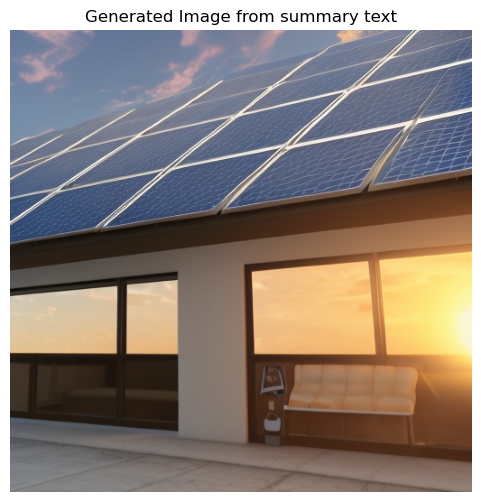

{'prompt': '{"prompt": "Convert this text Solar power is becoming a popular choice for homeowners due to its numerous benefits, including government incentives. into image with Highly Detailed, hyperrealistic, dynamic lighting, octane render, fancy highlights, intricate detail"}'}


In [ ]:
#Combine the summary_chain and text_to_image_chain using SequentialChain

prompt_specification = "Highly Detailed, hyperrealistic, dynamic lighting, octane render, fancy highlights, intricate detail"

#This is the overall chain where we run these summary_chain and text_to_image_chain in sequence.
overall_chain = SequentialChain(chains = [summary_chain, text_to_image_chain],
                                input_variables=["input_documents","prompt_specification"] , 
                                output_variables=["prompt"] #From text_to_image chain.
                                )
                               

#Run the combined chain by passing inputs to the chains
print(overall_chain({'prompt_specification':prompt_specification, 'input_documents':input_documents},return_only_outputs=True))
